<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Neural%20ML/Neural_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Модели
import torch
import torch.nn as nn

# Метрики качества
from time import time

from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install torchmetrics
from torchmetrics import R2Score

!pip install torcheval
from torcheval.metrics.functional import r2_score

#!pip install onnx
#!pip install hiddenlayer
#import hiddenlayer as hl
!pip install torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

# Обработка датасета
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

# Удобства
from tqdm import tqdm

# Шедуллер
from torch.optim.lr_scheduler import ReduceLROnPlateau

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Фиксация сида:

In [3]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Перенос модели на GPU:

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Скачивание предобработанного датасета

Загружаем датасет с GitHub:

In [5]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-05-15 16:26:24--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-05-15 16:26:24--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  14.66M  6.37MB/s    in 2.3s    

2023-05-15 16:26:26 (6.37 MB/s) - ‘/tmp/data.zip’ saved [15371365]



In [6]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


# Подготовка данных

Функция, которая будет делить датасет на два фрейма X и Y данных:

In [7]:
def split_df(df, param_general, param_save, mode_number):
    # general parameters - параметры, одинаковые для всех мод колебаний
    # parameters_to_use - параметры, которые мы хотим оставить
    # mode_number - число мод в датасете
    columns_to_get = []
    for mode_index in range(1, mode_number + 1):
        for parameter in param_save:
            columns_to_get.append(f'M{mode_index} ' + parameter)
    return df[param_general], df[columns_to_get]

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [8]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Выбираем параметры, с которыми будем работать:

In [9]:
param_general = ['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)', 'Pretension (Pa)']
param_save = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

Разделение данных на тренировочную, валидационную и тестовую части:

In [10]:
x_train, y_train = split_df(df_train, param_general=param_general, param_save=param_save, mode_number=4)
x_val, y_val = split_df(df_val, param_general=param_general, param_save=param_save, mode_number=4)
x_test, y_test = split_df(df_test, param_general=param_general, param_save=param_save, mode_number=4)

param_names_x = list(x_train.columns)
param_names_y = list(y_train.columns)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


Применение log10-шкалы к данным и последующая нормировка данных с помощью `StandardScaler`. Внимание: выполняется отдельный скейлинг по Х и У данным.

In [11]:
class Scaler():
    def __init__(self, scaler_type='standard'):
        if scaler_type == 'standard':
            self.s_x = StandardScaler()
            self.s_y = StandardScaler()
        elif scaler_type == 'robust':
            self.s_x = RobustScaler()
            self.s_y = RobustScaler()
        
    def fit(self, x_train, y_train, log_params=None):
        # Функция логарифмирует параметры и загружает нормировку тренировочной выборки
        # log_params - список с параметрами, которые нужно предварительно прологарифмировать
        #   по умолчанию стоят резонансная частота, эффективная масса и термоупругие потери;
        #   принудительно логарифмируются длина и температура
        self.cols_x = x_train.columns
        self.cols_y = y_train.columns
        self.log_params = log_params

        # Логарифмирование нескольких колонок в Х-данных
        x_train.loc[:, 'Beam length (um)'] = np.log10(x_train.loc[:, 'Beam length (um)'])
        x_train.loc[:, 'Temperature (K)'] = np.log10(x_train.loc[:, 'Temperature (K)'])

        # Логарифмирование У-данных
        if self.log_params == None:
            self.log_params = ['Eigenfrequency (Hz)','Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

        for mode_number in range(1, 5):
            for param in self.log_params:
                y_train.loc[:, f'M{mode_number} ' + param] = np.log10(y_train.loc[:, f'M{mode_number} ' + param])

        # Обучение скейлера
        self.s_x.fit(x_train)
        self.s_y.fit(y_train)

    def transform(self, x, y):
        # Функция логарифмирует параметры и выполняет скейлинг данных

        # Логарифмирование
        x.loc[:, 'Beam length (um)'] = np.log10(x.loc[:, 'Beam length (um)'])
        x.loc[:, 'Temperature (K)'] = np.log10(x.loc[:, 'Temperature (K)'])

        for mode_number in range(1, 5):
            for param in self.log_params:
                y.loc[:, f'M{mode_number} ' + param] = np.log10(y.loc[:, f'M{mode_number} ' + param])
        
        # Скейлинг
        x = pd.DataFrame(self.s_x.transform(x))
        x.columns = self.cols_x

        y = pd.DataFrame(self.s_y.transform(y))
        y.columns = self.cols_y

        return x, y
    
    def reverse_transform(self, x_test, y_pred, concat_required: bool):
        # concat_required - если True, то соединит X- и Y-данные в один DataFrame

        # Un-скейлинг
        x_test = pd.DataFrame(self.s_x.inverse_transform(x_test))
        x_test.columns = self.cols_x

        y_pred = pd.DataFrame(self.s_y.inverse_transform(y_pred))
        y_pred.columns = self.cols_y

        # Возведение в степень
        x_test.loc[:, 'Beam length (um)'] = np.power(10, x_test.loc[:, 'Beam length (um)'])
        x_test.loc[:, 'Temperature (K)'] = np.power(10, x_test.loc[:, 'Temperature (K)'])
        
        for mode_number in range(1, 5):
            for param in self.log_params:
                y_pred.loc[:, f'M{mode_number} ' + param] = np.power(10, y_pred.loc[:, f'M{mode_number} ' + param])

        if concat_required:
            return pd.concat([x_test, y_pred], axis=1)
        else:
            return x_test, y_pred

    def transform_real_x(self, x):
        # Функция логарифмирует реальные значения X и выполняет скейлинг данных

        # Логарифмирование
        x.loc[:, 'Beam length (um)'] = np.log10(x.loc[:, 'Beam length (um)'])
        x.loc[:, 'Temperature (K)'] = np.log10(x.loc[:, 'Temperature (K)'])
        
        # Скейлинг
        x = pd.DataFrame(self.s_x.transform(x))
        x.columns = self.cols_x

        return x
    
    def transform_real_y(self, y):
        # Функция логарифмирует реальные значения Y и выполняет скейлинг данных

        # Логарифмирование
        for mode_number in range(1, 5):
            for param in self.log_params:
                y.loc[:, f'M{mode_number} ' + param] = np.log10(y.loc[:, f'M{mode_number} ' + param])
        
        # Скейлинг
        y = pd.DataFrame(self.s_y.transform(y))
        y.columns = self.cols_y

        return y

In [12]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12,1.652589e+06,2.179432e+06,3.360062e-14,2.047043e-29,1.705975e-11,2.492992e+06,2.138282e+06,3.363194e-14,3.150402e-29,2.224337e-11,3.350131e+06,1.953502e+06,3.366659e-14,4.638795e-29,2.730320e-11
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12,8.950608e+07,8.741688e+04,1.780460e-15,1.034411e-22,3.956188e-12,1.634791e+08,6.489439e+04,1.773305e-15,2.534792e-22,4.171862e-12,2.560639e+08,5.143171e+04,1.759506e-15,4.970636e-22,4.369109e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11,8.167046e+06,6.037550e+07,1.029027e-14,2.094931e-30,1.748103e-11,1.256789e+07,5.489475e+07,1.036000e-14,3.569687e-30,2.206222e-11,1.732588e+07,4.940941e+07,1.039743e-14,5.487195e-30,2.605582e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12,1.127357e+08,3.688876e+04,2.603435e-15,9.736272e-26,3.848615e-12,2.067481e+08,3.532490e+04,2.583663e-15,1.850441e-25,4.200149e-12,3.232575e+08,3.457247e+04,2.556074e-15,2.924626e-25,4.656986e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13,6.131970e+06,1.006085e+09,2.964966e-14,1.132194e-32,5.494210e-12,9.438750e+06,8.997463e+08,2.985198e-14,1.962020e-32,1.288137e-11,1.301669e+07,8.200638e+08,2.995975e-14,2.979387e-32,1.521141e-11


Выполняем логарифмирование и скейлинг:

In [13]:
log_params = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

s = Scaler(scaler_type='standard')
s.fit(x_train=x_train.copy(), y_train=y_train.copy(), log_params=log_params)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [14]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.014167,-0.006174,0.025109,0.013023,0.008054,-0.013916,-0.006343,0.024551,0.002942,0.007557,-0.014963,-0.006363,0.024660,-0.004944,0.007016,-0.007708,-0.006983,0.021198,-0.008800
std,0.988296,0.961995,0.980944,0.988541,0.984973,0.989626,0.963986,0.980410,0.990055,0.982179,0.990671,0.964596,0.980489,0.990604,0.972298,0.991183,0.973177,0.982377,0.995477,0.968027
min,-2.210503,-2.607106,-2.922469,-2.305750,-3.902680,-2.127390,-2.584861,-2.962526,-2.293187,-4.179475,-2.081414,-2.565005,-2.962160,-2.289673,-4.170642,-2.053933,-2.643954,-2.904239,-2.465779,-4.017885
25%,-0.764214,-0.696085,-0.714197,-0.681071,-0.555324,-0.764181,-0.706019,-0.699185,-0.682143,-0.422503,-0.769533,-0.703914,-0.700720,-0.686954,-0.489975,-0.775452,-0.694660,-0.682452,-0.697956,-0.514381
50%,-0.023415,-0.068124,-0.015231,0.061847,0.294927,-0.050238,-0.053054,-0.015728,0.057023,0.173135,-0.075644,-0.052964,-0.015262,0.053236,0.093081,-0.088919,-0.047806,-0.002947,0.056189,0.043985
75%,0.712678,0.682357,0.743511,0.773055,0.726739,0.691099,0.700989,0.737272,0.761989,0.654429,0.713913,0.700747,0.735649,0.751653,0.632641,0.720316,0.716392,0.735474,0.738864,0.655614
max,2.345348,2.479744,2.259412,2.881269,2.064679,2.397605,2.476387,2.267635,2.878661,2.222553,2.403320,2.453312,2.266518,2.853652,2.301370,2.239074,3.003916,2.242780,2.784347,2.308940


Вводим новые переменные для простоты дальнейших расчетов:

In [15]:
# Количество колонок в X-данных
num_cols_x = x_train.shape[1]

# Количество колонок в Y-данных
num_cols_y = y_train.shape[1]

# Названия параметров в колонках X-данных
cols_x = list(x_train.columns)

# Названия параметров в колонках X-данных
cols_y = list(y_train.columns)

# Визуализация распределения параметров

Функция для визуализации распределений:

In [ ]:
def plot_distribution_legacy(df, indices_to_plot: list, col_names, log_scale):
    fig, ax = plt.subplots(nrows=1, ncols=len(indices_to_plot), figsize=(5 * len(indices_to_plot), 5))
    for j in range(0, len(indices_to_plot)):
        sns.histplot(df.iloc[:, indices_to_plot[j]], ax=ax[j], log_scale=log_scale)
        ax[j].set_title(f"{col_names[indices_to_plot[j]]} distribution.", fontsize=2 * (len(indices_to_plot) + 1))
        ax[j].set_xlabel(col_names[indices_to_plot[j]])
        ax[j].set_ylabel('Count')
    plt.show()

In [ ]:
def plot_distribution(df, indices_to_plot, log_scale: bool):
    col_names = list(df.columns)
    plot_distribution_legacy(df, indices_to_plot=indices_to_plot, col_names=col_names, log_scale=log_scale)

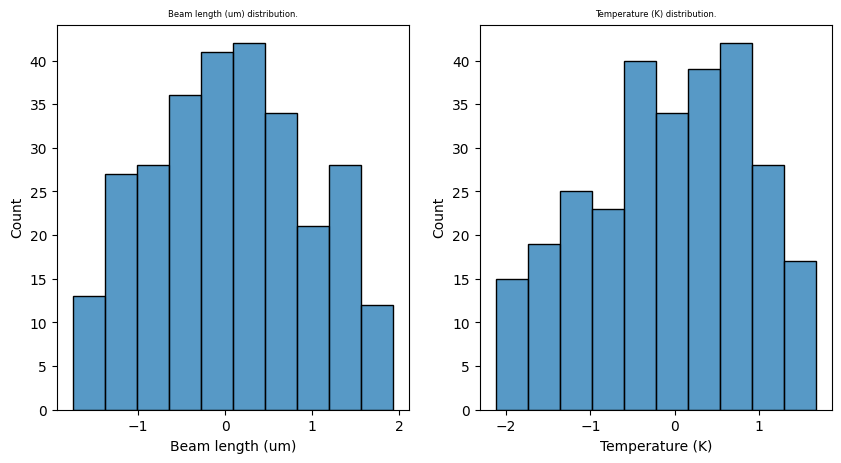

In [ ]:
plot_distribution(x_test, indices_to_plot=[0, 4], log_scale=False)

In [ ]:
y_train.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
count,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02,9.010000e+02
mean,-8.093169e-16,-1.695524e-16,-7.107399e-16,1.332761e-15,-4.909133e-16,7.531280e-16,3.154463e-17,-1.345576e-15,-8.438188e-16,1.148422e-16,8.132599e-16,-3.272755e-16,1.319946e-15,-8.773350e-16,1.166165e-15,-4.830271e-17,1.695524e-16,-1.232212e-15,-2.484139e-16,2.605389e-15
std,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00,1.000555e+00
min,-2.836144e+00,-2.546181e+00,-2.700286e+00,-2.454628e+00,-3.545562e+00,-2.763494e+00,-2.522936e+00,-2.740980e+00,-2.438933e+00,-3.695066e+00,-2.698930e+00,-2.499934e+00,-2.741569e+00,-2.431028e+00,-3.642223e+00,-2.655399e+00,-2.597651e+00,-2.671883e+00,-2.482432e+00,-3.481317e+00
25%,-8.046686e-01,-7.478496e-01,-7.574125e-01,-7.571430e-01,-5.750802e-01,-8.064851e-01,-7.400744e-01,-7.465605e-01,-7.525724e-01,-4.265827e-01,-8.027039e-01,-7.531686e-01,-7.462232e-01,-7.370789e-01,-5.001358e-01,-8.074371e-01,-7.500208e-01,-7.195335e-01,-7.366826e-01,-5.678574e-01
50%,-5.412657e-02,-4.255502e-02,4.199125e-02,1.048132e-01,2.906410e-01,-7.270600e-02,-5.129570e-02,3.514809e-02,9.558897e-02,1.819565e-01,-8.555769e-02,-4.620153e-02,3.813174e-02,1.002033e-01,1.036876e-01,-9.716281e-02,-3.911281e-02,5.218535e-02,8.735969e-02,3.958393e-02
75%,7.534015e-01,7.646371e-01,7.825815e-01,7.528245e-01,7.084878e-01,7.617247e-01,7.769025e-01,7.756739e-01,7.509590e-01,7.023244e-01,7.491634e-01,7.776996e-01,7.746946e-01,7.401001e-01,7.110473e-01,7.384123e-01,7.622228e-01,7.746087e-01,7.556856e-01,7.252805e-01
max,2.240152e+00,2.576994e+00,2.344791e+00,2.771113e+00,1.842125e+00,2.285211e+00,2.572891e+00,2.353436e+00,2.766913e+00,2.065237e+00,2.288503e+00,2.562755e+00,2.352177e+00,2.741586e+00,2.158988e+00,2.118594e+00,2.634923e+00,2.320531e+00,2.687286e+00,2.260170e+00


# Формирование подвыборок

Определение кастомного датасета:

In [16]:
class CustomDataset(Dataset):
    def __init__(self, x, y, cols_to_save=None):
        if cols_to_save == None:
            self.x = torch.tensor(x.iloc[:, :].values, dtype=torch.float32)
            self.y = torch.tensor(y.iloc[:, :].values, dtype=torch.float32)
        else:
            self.x = torch.tensor(x.iloc[:, :].values, dtype=torch.float32)
            self.y = torch.tensor(y.iloc[:, cols_to_save].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

Определение подвыборок и даталоадеров:

In [17]:
#cols_to_save = [15, 16, 17, 18, 19]
cols_to_save = None
trainset = CustomDataset(x_train, y_train, cols_to_save)
valset = CustomDataset(x_val, y_val, cols_to_save)
testset = CustomDataset(x_test, y_test, cols_to_save)

batch_size = 64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [18]:
print(len(train_loader))

50


# Модель Fully Connected + Batch Norm

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Функция для вычисления метрик по каждому параметру:

In [20]:
def calculate_metrics_torch(y_true, y_pred, param_names):
    output_dict = {}

    for index, name in enumerate(param_names):
        output_dict[name] = []
        output_dict[name].append(mse_loss(input=y_pred[:, index], target=y_true[:, index]))
        output_dict[name].append(r2_score(input=y_pred[:, index], target=y_true[:, index]))
    
    return output_dict

### Функции для обучения

In [21]:
from IPython.display import clear_output
from collections import defaultdict

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value) # тут можно хранить разные величины

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  def display(self, groups = None): 
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [22]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calculate_val_metrics_mlp(model, data_loader, criterion):
    y_log = torch.empty(size=[0, 20]).to(device)
    output_log = torch.empty(size=[0, 20]).to(device)

    for batch in data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        output = model(x)
        y_log = torch.cat((y_log, y), dim=0)
        output_log = torch.cat((output_log, output), dim=0)

    output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
        
    return output_dict

In [23]:
def train_mlp(model, criterion, optimizer, scheduler, num_epochs=10, tag="cifar10"):
    pp = ProgressPlotter()

    for epoch in range(num_epochs):
        y_log = torch.empty(size=[0, 20]).to(device)
        output_log = torch.empty(size=[0, 20]).to(device)

        model.train()
        for batch in train_loader:     # кусок данных для обучения
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            output = model(x) # загружаем данные в модель
            loss = criterion(output, y) # считаем ошибку

            y_log = torch.cat((y_log, y), dim=0)
            output_log = torch.cat((output_log, output), dim=0)

            loss.backward()
            optimizer.step()

        # Берем все объекты из тренировочного даталоадера и считаем метрики
        output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)

        # Logging
        if epoch % 10 ==0:
            pp.add_scalar('MSE_train', output_dict['M1 Quality factor'][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict['M1 Quality factor'][1].cpu().detach().numpy())

        model.eval()
        output_dict_val = calculate_val_metrics_mlp(model, val_loader, criterion)

        scheduler.step(output_dict_val['M1 Quality factor'][0])

        if epoch % 10 ==0:
            pp.add_scalar('MSE_val', output_dict_val['M1 Quality factor'][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val['M1 Quality factor'][1].cpu().detach().numpy())

        if epoch % 10 ==0:
            #pp.display([['loss_train', 'loss_val']])
            pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
    return pp

### Построение модели

In [24]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

class FCNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=num_pars_y, bias=True),
        )
    
    def forward(self, x):
        out = self.network(x)
        return out
    
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

### Процесс обучения модели

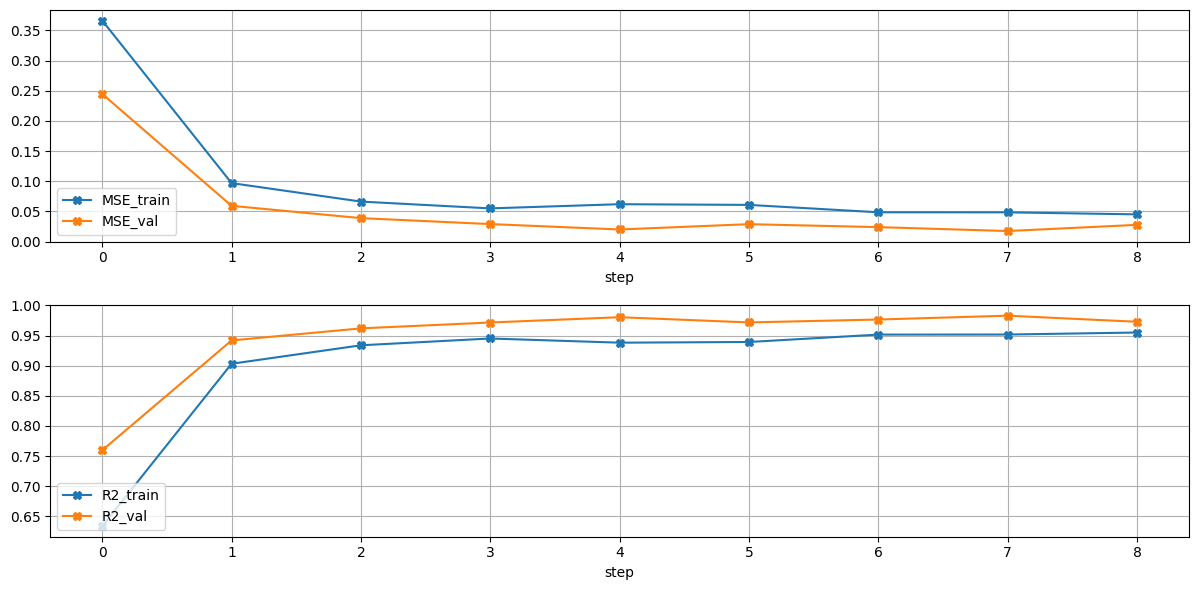

In [25]:
model_mlp = FCNetwork().to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
pp = train_mlp(model_mlp, criterion, optimizer, scheduler, num_epochs=90)

Проверка на тестовом датасете:

In [26]:
loss = 0
y_log = torch.empty(size=[0, 20]).to(device)
output_log = torch.empty(size=[0, 20]).to(device)

for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)

    output = model_mlp(x)

    y_log = torch.cat((y_log, y), dim=0)
    output_log = torch.cat((output_log, output), dim=0)

    loss += mse_loss(output, y).item()

output_dict_test_mlp = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
for name in output_dict_test_mlp.keys():
    for index in range(0, len(output_dict_test_mlp[name])):
        output_dict_test_mlp[name][index] = output_dict_test_mlp[name][index].item()
print(output_dict_test_mlp)

{'M1 Eigenfrequency (Hz)': [0.006585056893527508, 0.9932512044906616], 'M1 Quality factor': [0.021778473630547523, 0.9764427542686462], 'M1 Effective mass (kg)': [0.00330421794205904, 0.996562659740448], 'M1 TED (W)': [0.008151499554514885, 0.9916499257087708], 'M1 Noise (kg^2/s^3)': [0.021161602810025215, 0.9781655669212341], 'M2 Eigenfrequency (Hz)': [0.0062857442535459995, 0.9935752153396606], 'M2 Quality factor': [0.02099411003291607, 0.9773849248886108], 'M2 Effective mass (kg)': [0.0031852228567004204, 0.9966828227043152], 'M2 TED (W)': [0.007416076492518187, 0.9924264550209045], 'M2 Noise (kg^2/s^3)': [0.026550881564617157, 0.9724488258361816], 'M3 Eigenfrequency (Hz)': [0.00644438061863184, 0.9934269785881042], 'M3 Quality factor': [0.020509513095021248, 0.9779348373413086], 'M3 Effective mass (kg)': [0.003079516114667058, 0.9967934489250183], 'M3 TED (W)': [0.007375537417829037, 0.992476224899292], 'M3 Noise (kg^2/s^3)': [0.03042621724307537, 0.9677825570106506], 'M4 Eigenfreq

Измерение времени работы нейросетевой модели:

In [27]:
from pandas.io.parquet import StorageOptions
def get_elapsed_time(model, data_loader, num_samples):
    samples_x = torch.empty(size=[0, num_cols_x]).to(device)
    for batch in data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        samples_x = torch.cat((samples_x, x), dim=0)

        if samples_x.shape[0] > num_samples:
            break

    samples_x = samples_x[:200, :]

    time_start = time()
    samples_y = model(samples_x)
    time_stop = time()

    return time_stop - time_start

print(get_elapsed_time(model=model_mlp, data_loader=train_loader, num_samples=200))

0.0018906593322753906


### Визуализация структуры модели

In [ ]:
model_mlp_graph = FCNetwork()

model_graph = draw_graph(model_mlp_graph, input_size=(256,7))
model_graph.visual_graph

# Тандем нейросетей

### Создание нового даталоадера на основе предсказаний forward-модели для всего датасета 

Собираем все подвыборки x-данных в один датафрейм:

In [28]:
x_all = pd.concat([x_train, x_val, x_test], axis=0)

Функция для сбора предсказаний для всего датасета:

In [29]:
def gather_dataset_predictions(model_forward, x_all):
    '''
    Returns predictions of `model_forward` to all dataset.
    - model_forward - model to predict data
    - x_all - scaled data of pd.DataFrame type
    '''

    x = torch.tensor(x_all.iloc[:, :].values, dtype=torch.float32).to(device)

    model_forward.eval()
    with torch.no_grad():
        y_pred = model_forward(x)
    
    y_pred_pd = pd.DataFrame(y_pred.detach().cpu().numpy())
    y_pred_pd.columns = y_train.columns

    return y_pred_pd

Заводим даталоадер, в котором y-данные будут результатами предсказаний модели:

In [30]:
y_all = gather_dataset_predictions(model_forward=model_mlp, x_all=x_all)
fullset = CustomDataset(x_all, y_all, cols_to_save)

batch_size = 96

full_loader = DataLoader(fullset, batch_size=batch_size, shuffle=False, num_workers=2)

print(len(full_loader))

52


### Функции для обучения

In [31]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calculate_val_metrics_tandem(model_inverse, model_forward, data_loader, criterion):
    # Logs for X-data
    x_log = torch.empty(size=[0, num_cols_x]).to(device)
    output_inverse_log = torch.empty(size=[0, num_cols_x]).to(device)

    # Logs for Y-data
    y_log = torch.empty(size=[0, num_cols_y]).to(device)
    output_forward_log = torch.empty(size=[0, num_cols_y]).to(device)

    model_inverse.eval()
    model_forward.eval()

    for batch in data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Obtaining predictions of inverse and then forward model predictions
        output_inverse = model_inverse(y)
        output_forward = model_forward(output_inverse)

        x_log = torch.cat((x_log, x), dim=0)
        y_log = torch.cat((y_log, y), dim=0)
        output_inverse_log = torch.cat((output_inverse_log, output_inverse), dim=0)
        output_forward_log = torch.cat((output_forward_log, output_forward), dim=0)

    output_dict_inverse = calculate_metrics_torch(y_true=x_log, y_pred=output_inverse_log, param_names=cols_x)
    output_dict_forward = calculate_metrics_torch(y_true=y_log, y_pred=output_forward_log, param_names=cols_y)
        
    return output_dict_inverse, output_dict_forward

In [32]:
def train_tandem(model_inverse, model_forward, data_loader, criterion, optimizer, scheduler, plot_param, num_epochs=10, tag="cifar10"):
    pp = ProgressPlotter()

    model_forward.eval()

    for epoch in range(num_epochs):
        # Logs for X-data
        x_log = torch.empty(size=[0, num_cols_x]).to(device)
        output_inverse_log = torch.empty(size=[0, num_cols_x]).to(device)

        # Logs for Y-data
        y_log = torch.empty(size=[0, num_cols_y]).to(device)
        output_forward_log = torch.empty(size=[0, num_cols_y]).to(device)

        model_inverse.train()
        for batch in data_loader:     # кусок данных для обучения
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()


            # Obtaining predictions of inverse and then forward model predictions
            output_inverse = model_inverse(y)
            output_forward = model_forward(output_inverse)

            loss = criterion(output_forward, y) # calculating loss
            loss.backward()
            optimizer.step()

            x_log = torch.cat((x_log, x), dim=0)
            y_log = torch.cat((y_log, y), dim=0)
            output_inverse_log = torch.cat((output_inverse_log, output_inverse), dim=0)
            output_forward_log = torch.cat((output_forward_log, output_forward), dim=0)

        # Берем все объекты из тренировочного даталоадера и считаем метрики
        output_dict_inverse = calculate_metrics_torch(y_true=x_log, y_pred=output_inverse_log, param_names=param_names_x)
        output_dict_forward = calculate_metrics_torch(y_true=y_log, y_pred=output_forward_log, param_names=param_names_y)

        output_dict_val_inverse, output_dict_val_forward = calculate_val_metrics_tandem(model_inverse, model_forward, data_loader, criterion)

        # Scheduler step
        if plot_param in cols_x:
            scheduler.step(output_dict_val_inverse[plot_param][0])
        elif plot_param in cols_y:
            scheduler.step(output_dict_val_forward[plot_param][0])

        # Logging
        if epoch % 10 ==0:
            if plot_param in cols_x:
                pp.add_scalar('MSE_train', output_dict_val_inverse[plot_param][0].cpu().detach().numpy())
                pp.add_scalar('R2_train', output_dict_val_inverse[plot_param][1].cpu().detach().numpy())
                pp.add_scalar('MSE_val', output_dict_val_inverse[plot_param][0].cpu().detach().numpy())
                pp.add_scalar('R2_val', output_dict_val_inverse[plot_param][1].cpu().detach().numpy())

                # Displaying current results
                pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
            
            elif plot_param in cols_y:
                pp.add_scalar('MSE_train', output_dict_val_forward[plot_param][0].cpu().detach().numpy())
                pp.add_scalar('R2_train', output_dict_val_forward[plot_param][1].cpu().detach().numpy())
                pp.add_scalar('MSE_val', output_dict_val_forward[plot_param][0].cpu().detach().numpy())
                pp.add_scalar('R2_val', output_dict_val_forward[plot_param][1].cpu().detach().numpy())

                # Displaying current results
                pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
    return pp

### Сборка inverse-модели:

In [33]:
class InverseFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=num_pars_y, out_features=200, bias=False),
            nn.BatchNorm1d(num_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=1000, bias=False),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=num_pars_x, bias=True),
        )
    
    def forward(self, x):
        out = self.network(x)
        return out
    
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

### Процесс обучения:

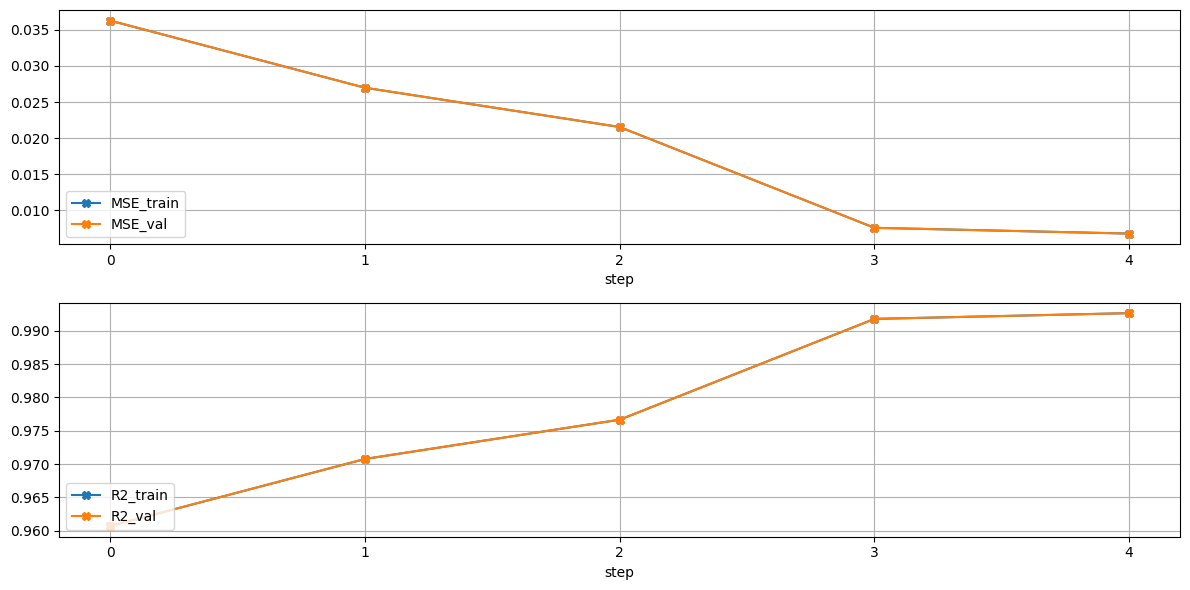

In [34]:
model_inverse = InverseFC().to(device)
model_forward = deepcopy(model_mlp).to(device)
optimizer = torch.optim.Adam(model_inverse.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)

plot_param = 'M1 Quality factor'
pp = train_tandem(model_inverse, model_forward, full_loader, 
                  criterion, optimizer, scheduler, 
                  plot_param, num_epochs=50)

# Модель Branched Fully Connected

### Функции для обучения

Функция для вычисления метрик по каждому параметру:

In [ ]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

In [ ]:
def calculate_metrics_torch(y_true, y_pred, param_names):
    output_dict = {}

    if (y_true.shape[1] != y_pred.shape[1]) or (y_true.shape[1] != len(param_names)):
        print(f'Wrong shapes of input, got y_true, y_pred, param names shapes as ({y_true.shape[1]}, {y_pred.shape[1]}, {len(param_names)}) '+
              'but they must be equal!')

    for index, name in enumerate(param_names):
        output_dict[name] = []
        output_dict[name].append(mse_loss(input=y_pred[:, index], target=y_true[:, index]))
        output_dict[name].append(r2_score(input=y_pred[:, index], target=y_true[:, index]))
    
    return output_dict

In [ ]:
from IPython.display import clear_output
from collections import defaultdict

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value) # тут можно хранить разные величины

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  def display(self, groups = None): 
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [ ]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calculate_val_metrics_branched(model, data_loader, criterion):
    y_log = torch.empty(size=[0, num_pars_y]).to(device)
    output_log = torch.empty(size=[0, num_pars_y]).to(device)

    for batch in data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        output_1, output_2 = model(x)
        #output = (output_1 * 0.5).add(output_2 * 0.5)
        output = output_2
        y_log = torch.cat((y_log, y), dim=0)
        output_log = torch.cat((output_log, output), dim=0)

    # Можно считать метрики не по всем параметрам, а только по четвертой моде!
    output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
        
    return output_dict

In [ ]:
def train_branched(model, criterion, optimizer, scheduler, plot_par, num_epochs=10, loss_coeffs=[0.2, 1], tag="cifar10"):
    pp = ProgressPlotter()

    for epoch in range(num_epochs):
        y_log = torch.empty(size=[0, num_pars_y]).to(device)
        output_log = torch.empty(size=[0, num_pars_y]).to(device)

        model.train()
        for batch in train_loader:     # кусок данных для обучения
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            output_1, output_2 = model(x) # загружаем данные в модель
            loss_1 = criterion(output_1, y) # считаем ошибку
            loss_2 = criterion(output_2, y)
            loss = loss_coeffs[0] * loss_1 + loss_coeffs[1] * loss_2

            # output = (output_1 * 0.5).add(output_2 * 0.5) - раскомментить, если хотите поиграться с идеей слияния короткой и длинной ветвей
            output = output_2 # берем в качестве выхода модели выход длинной ветви

            y_log = torch.cat((y_log, y), dim=0)
            output_log = torch.cat((output_log, output), dim=0)

            loss.backward()
            optimizer.step()

        # Берем все объекты из тренировочного даталоадера и считаем метрики
        output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)

        # Logging
        if epoch % 10 ==0:
            pp.add_scalar('MSE_train', output_dict[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict[plot_par][1].cpu().detach().numpy())

        model.eval()
        output_dict_val = calculate_val_metrics_branched(model, val_loader, criterion)

        scheduler.step(output_dict_val[plot_par][0])

        if epoch % 10 ==0:
            pp.add_scalar('MSE_val', output_dict_val[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val[plot_par][1].cpu().detach().numpy())

        if epoch % 10 ==0:
            #pp.display([['loss_train', 'loss_val']])
            pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
    return pp

### Построение модели

In [ ]:
#num_pars_x = x_train.shape[1]
#num_pars_y = y_train.shape[1]

class BranchedFCNetwork(nn.Module):
    def __init__(self, neck_features):
        super().__init__()
        self.network_general = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=300, bias=False),
            nn.BatchNorm1d(num_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=int(neck_features / 2), bias=False),
            nn.BatchNorm1d(num_features=int(neck_features / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(neck_features / 2), out_features=neck_features, bias=True),
            nn.ReLU()
        )

        # Короткая ветвь
        self.network_short = nn.Linear(in_features=neck_features, out_features=num_pars_y, bias=True)

        # Хранилище длинных ветвей
        self.network_branches = nn.ModuleList()

        # Длинные ветви
        for branch_index in range(0, num_pars_y):
            self.network_branches.append(BranchBlock(in_features=neck_features))
        
        # Длинные ветви для 4 моды
        #for branch_index in range(0, 1):
        #    self.network_branches.append(BranchBlockM4(in_features=neck_features))
    


    def forward(self, x):
        batch_size_x = x.shape[0]

        # Проходим по общим слоям
        x = self.network_general(x)

        # Прохожим по короткой ветви
        out_1 = self.network_short(x)

        # Проходим по длинным ветвям
        out_2 = torch.empty(size=[batch_size_x, 0]).to(device)
        for branch_index in range(0, num_pars_y):
            out_temp = self.network_branches[branch_index](x)
            out_2 = torch.cat((out_2, out_temp), dim=1)
        
        return out_1, out_2
    
    # Инициализация весов
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()


# Блок длинной ветви для 1, 2 и 3 мод (НЕ ИСПОЛЬЗУЕТСЯ)
class BranchBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1, bias=False)
        )
    
    def forward(self, x):
        out = self.network(x)
        return out



# Блок длинной ветви для 4 моды
class BranchBlockM4(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=100, bias=False),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=1, bias=False)
        )
    
    def forward(self, x):
        out = self.network(x)
        return out

### Процесс обучения модели

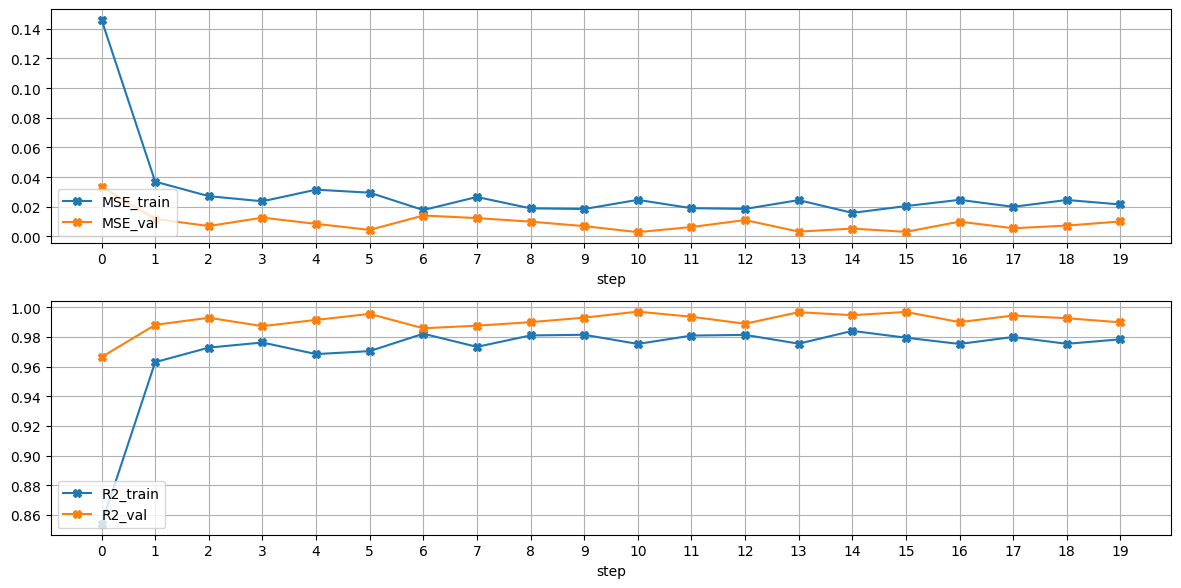

In [ ]:
model_branched = BranchedFCNetwork(neck_features=1000).to(device)
optimizer = torch.optim.Adam(model_branched.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
criterion = nn.MSELoss()
plot_par = 'M1 Quality factor'
pp = train_branched(model_branched, criterion, optimizer, scheduler, plot_par, num_epochs=200, loss_coeffs=[10, 1])

Проверка на тестовом датасете:

In [ ]:
loss = 0
y_log = torch.empty(size=[0, 20]).to(device)
output_log = torch.empty(size=[0, 20]).to(device)

for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)

    output_1, output_2 = model_branched(x)
    output = (output_1 * 0.5).add(output_2 * 0.5)

    y_log = torch.cat((y_log, y), dim=0)
    output_log = torch.cat((output_log, output), dim=0)

    loss += mse_loss(output, y).item()

output_dict_test_branched = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
for name in output_dict_test_branched.keys():
    for index in range(0, len(output_dict_test_branched[name])):
        output_dict_test_branched[name][index] = output_dict_test_branched[name][index].item()
print(output_dict_test_branched)

{'M1 Eigenfrequency (Hz)': [0.004104258958250284, 0.9957937002182007], 'M1 Quality factor': [0.02100984938442707, 0.9772741794586182], 'M1 Effective mass (kg)': [0.00352505873888731, 0.9963329434394836], 'M1 TED (W)': [0.009135810658335686, 0.9906416535377502], 'M1 Noise (kg^2/s^3)': [0.018049409613013268, 0.9813767075538635], 'M2 Eigenfrequency (Hz)': [0.003815657692030072, 0.9960999488830566], 'M2 Quality factor': [0.019848201423883438, 0.9786192774772644], 'M2 Effective mass (kg)': [0.0034978778567165136, 0.9963572025299072], 'M2 TED (W)': [0.00872055348008871, 0.9910942912101746], 'M2 Noise (kg^2/s^3)': [0.02279409021139145, 0.9763471484184265], 'M3 Eigenfrequency (Hz)': [0.0036470505874603987, 0.9962801337242126], 'M3 Quality factor': [0.020915325731039047, 0.9774982333183289], 'M3 Effective mass (kg)': [0.003398467553779483, 0.9964613318443298], 'M3 TED (W)': [0.008954047225415707, 0.9908660054206848], 'M3 Noise (kg^2/s^3)': [0.02569025196135044, 0.9727973341941833], 'M4 Eigenfre

### Визуализация структуры модели

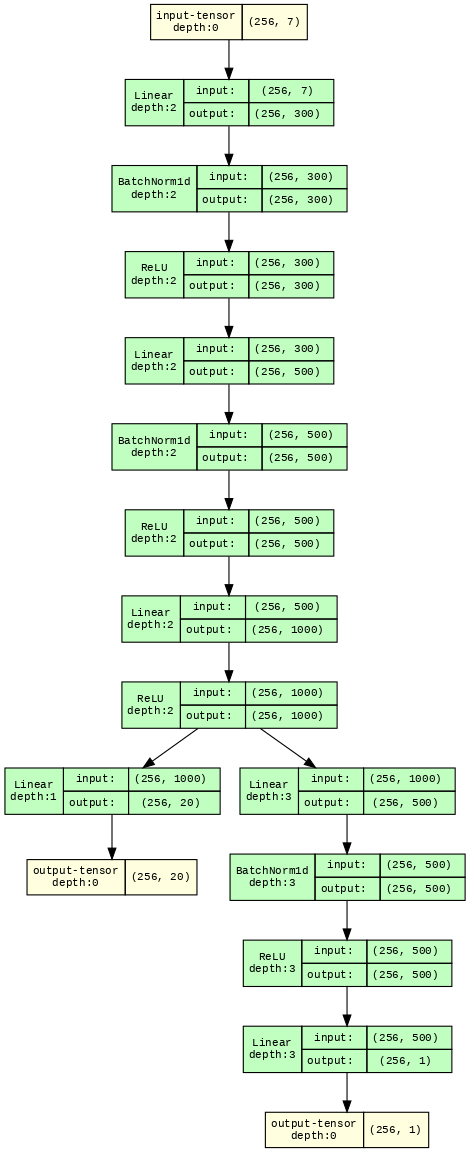

In [ ]:
model_branched_mlp_graph = BranchedFCNetwork(neck_features=1000)

model_graph = draw_graph(model_branched_mlp_graph, input_size=(256,7))
model_graph.visual_graph

# Модель Branched Fully Connected + Loss weight wrapper

### Функции для обучения

Функция для вычисления метрик по каждому параметру:

In [53]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

In [54]:
def calculate_metrics_torch(y_true, y_pred, param_names):
    output_dict = {}

    if (y_true.shape[1] != y_pred.shape[1]) or (y_true.shape[1] != len(param_names)):
        print(f'Wrong shapes of input, got y_true, y_pred, param names shapes as ({y_true.shape[1]}, {y_pred.shape[1]}, {len(param_names)}) '+
              'but they must be equal!')

    for index, name in enumerate(param_names):
        output_dict[name] = []
        output_dict[name].append(mse_loss(input=y_pred[:, index], target=y_true[:, index]))
        output_dict[name].append(r2_score(input=y_pred[:, index], target=y_true[:, index]))
    
    return output_dict

In [55]:
from IPython.display import clear_output
from collections import defaultdict

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value) # тут можно хранить разные величины

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  def display(self, groups = None): 
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [56]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calculate_val_metrics_branched(model, data_loader, criterion):
    y_log = torch.empty(size=[0, num_pars_y]).to(device)
    output_log = torch.empty(size=[0, num_pars_y]).to(device)

    for batch in data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        output_1, output_2 = model(x)
        #output = (output_1 * 0.5).add(output_2 * 0.5)
        output = output_2
        y_log = torch.cat((y_log, y), dim=0)
        output_log = torch.cat((output_log, output), dim=0)

    # Можно считать метрики не по всем параметрам, а только по четвертой моде!
    output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
        
    return output_dict

In [57]:
def train_branched(model, criterion, optimizer, scheduler, plot_par, num_epochs=10, loss_coeffs=[0.2, 1], tag="cifar10"):
    pp = ProgressPlotter()

    for epoch in range(num_epochs):
        y_log = torch.empty(size=[0, num_pars_y]).to(device)
        output_log = torch.empty(size=[0, num_pars_y]).to(device)

        model.train()
        for batch in train_loader:     # кусок данных для обучения
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            

            with torch.no_grad():
                output_1, output_2 = model(x) # загружаем данные в модель
            
            # output = (output_1 * 0.5).add(output_2 * 0.5) - раскомментить, если хотите поиграться с идеей слияния короткой и длинной ветвей
            output = output_2 # берем в качестве выхода модели выход длинной ветви

            y_log = torch.cat((y_log, y), dim=0)
            output_log = torch.cat((output_log, output), dim=0)

            loss.backward()
            optimizer.step()

        # Берем все объекты из тренировочного даталоадера и считаем метрики
        output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)

        # Logging
        if epoch % 10 ==0:
            pp.add_scalar('MSE_train', output_dict[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict[plot_par][1].cpu().detach().numpy())

        model.eval()
        output_dict_val = calculate_val_metrics_branched(model, val_loader, criterion)

        scheduler.step(output_dict_val[plot_par][0])

        if epoch % 10 ==0:
            pp.add_scalar('MSE_val', output_dict_val[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val[plot_par][1].cpu().detach().numpy())

        if epoch % 10 ==0:
            #pp.display([['loss_train', 'loss_val']])
            pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
    return pp

### Работа с коэффициентами в ошибке

Класс, с помощью которого:
*   обучается модель
*   обучаются коэффициенты в функции ошибки



In [ ]:
class LossWrapper(nn.Module):
    def __init__(self, model, branch_num):
        # branch_num - количество выходов модели
        super(LossWrapper, self).__init__()
        self.model = model
        self.branch_num = branch_num

        # Определим дисперсии каждого выхода как обучаемый параметр
        self.vars = nn.Parameter(torch.zeros(size=(branch_num)).to(device))
    
    def forward(self, input, target):
        # Через это место будет обучаться сама модель
        output = self.model(input)

        precision_1 = torch.exp(-self.vars[0])
        precision_2 = torch.exp(-self.vars[1])

        # В двух строках ниже фигурирует одна и та же переменная 'target'.
        # Это связано с тем, что в данной модели (Branched MLP) два разных слагаемых
        # в лосс-функции предсказывают одно и то же.
        loss = torch.sum(precision_1 * (target - output[0]) * (target[0] - output[0]) + self.vars[0], -1)
        loss += torch.sum(precision_2 * (target - output[1]) * (target[0] - output[0]) + self.vars[1], -1)

        loss = torch.mean(loss)

        return loss, self.vars.data.tolist()

### Построение модели

In [ ]:
#num_pars_x = x_train.shape[1]
#num_pars_y = y_train.shape[1]

class BranchedFCNetwork(nn.Module):
    def __init__(self, neck_features):
        super().__init__()
        self.network_general = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=300, bias=False),
            nn.BatchNorm1d(num_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=int(neck_features / 2), bias=False),
            nn.BatchNorm1d(num_features=int(neck_features / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(neck_features / 2), out_features=neck_features, bias=True),
            nn.ReLU()
        )

        # Короткая ветвь
        self.network_short = nn.Linear(in_features=neck_features, out_features=num_pars_y, bias=True)

        # Хранилище длинных ветвей
        self.network_branches = nn.ModuleList()

        # Длинные ветви
        for branch_index in range(0, num_pars_y):
            self.network_branches.append(BranchBlock(in_features=neck_features))
        
        # Длинные ветви для 4 моды
        #for branch_index in range(0, 1):
        #    self.network_branches.append(BranchBlockM4(in_features=neck_features))
    


    def forward(self, x):
        batch_size_x = x.shape[0]

        # Проходим по общим слоям
        x = self.network_general(x)

        # Прохожим по короткой ветви
        out_1 = self.network_short(x)

        # Проходим по длинным ветвям
        out_2 = torch.empty(size=[batch_size_x, 0]).to(device)
        for branch_index in range(0, num_pars_y):
            out_temp = self.network_branches[branch_index](x)
            out_2 = torch.cat((out_2, out_temp), dim=1)
        
        return out_1, out_2
    
    # Инициализация весов
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()


# Блок длинной ветви для 1, 2 и 3 мод (НЕ ИСПОЛЬЗУЕТСЯ)
class BranchBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1, bias=False)
        )
    
    def forward(self, x):
        out = self.network(x)
        return out



# Блок длинной ветви для 4 моды
class BranchBlockM4(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=100, bias=False),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=1, bias=False)
        )
    
    def forward(self, x):
        out = self.network(x)
        return out

### Процесс обучения модели

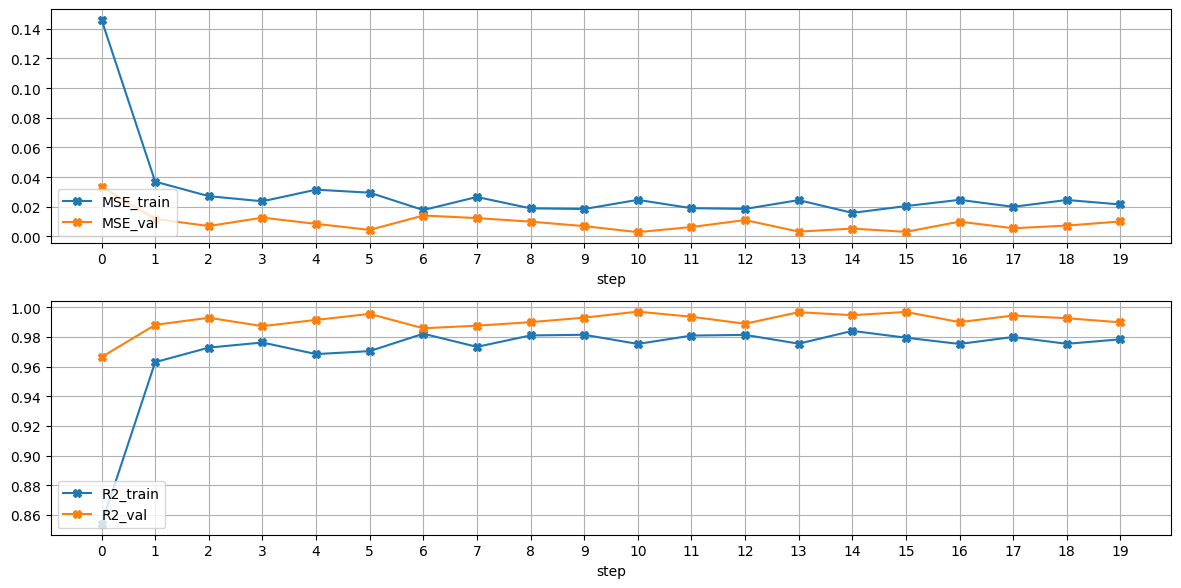

In [ ]:
model_branched = BranchedFCNetwork(neck_features=1000).to(device)
optimizer = torch.optim.Adam(model_branched.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
criterion = nn.MSELoss()
plot_par = 'M1 Quality factor'
pp = train_branched(model_branched, criterion, optimizer, scheduler, plot_par, num_epochs=200, loss_coeffs=[10, 1])

Проверка на тестовом датасете:

In [ ]:
loss = 0
y_log = torch.empty(size=[0, 20]).to(device)
output_log = torch.empty(size=[0, 20]).to(device)

for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)

    output_1, output_2 = model_branched(x)
    output = (output_1 * 0.5).add(output_2 * 0.5)

    y_log = torch.cat((y_log, y), dim=0)
    output_log = torch.cat((output_log, output), dim=0)

    loss += mse_loss(output, y).item()

output_dict_test_branched = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
for name in output_dict_test_branched.keys():
    for index in range(0, len(output_dict_test_branched[name])):
        output_dict_test_branched[name][index] = output_dict_test_branched[name][index].item()
print(output_dict_test_branched)

{'M1 Eigenfrequency (Hz)': [0.004104258958250284, 0.9957937002182007], 'M1 Quality factor': [0.02100984938442707, 0.9772741794586182], 'M1 Effective mass (kg)': [0.00352505873888731, 0.9963329434394836], 'M1 TED (W)': [0.009135810658335686, 0.9906416535377502], 'M1 Noise (kg^2/s^3)': [0.018049409613013268, 0.9813767075538635], 'M2 Eigenfrequency (Hz)': [0.003815657692030072, 0.9960999488830566], 'M2 Quality factor': [0.019848201423883438, 0.9786192774772644], 'M2 Effective mass (kg)': [0.0034978778567165136, 0.9963572025299072], 'M2 TED (W)': [0.00872055348008871, 0.9910942912101746], 'M2 Noise (kg^2/s^3)': [0.02279409021139145, 0.9763471484184265], 'M3 Eigenfrequency (Hz)': [0.0036470505874603987, 0.9962801337242126], 'M3 Quality factor': [0.020915325731039047, 0.9774982333183289], 'M3 Effective mass (kg)': [0.003398467553779483, 0.9964613318443298], 'M3 TED (W)': [0.008954047225415707, 0.9908660054206848], 'M3 Noise (kg^2/s^3)': [0.02569025196135044, 0.9727973341941833], 'M4 Eigenfre

### Визуализация структуры модели

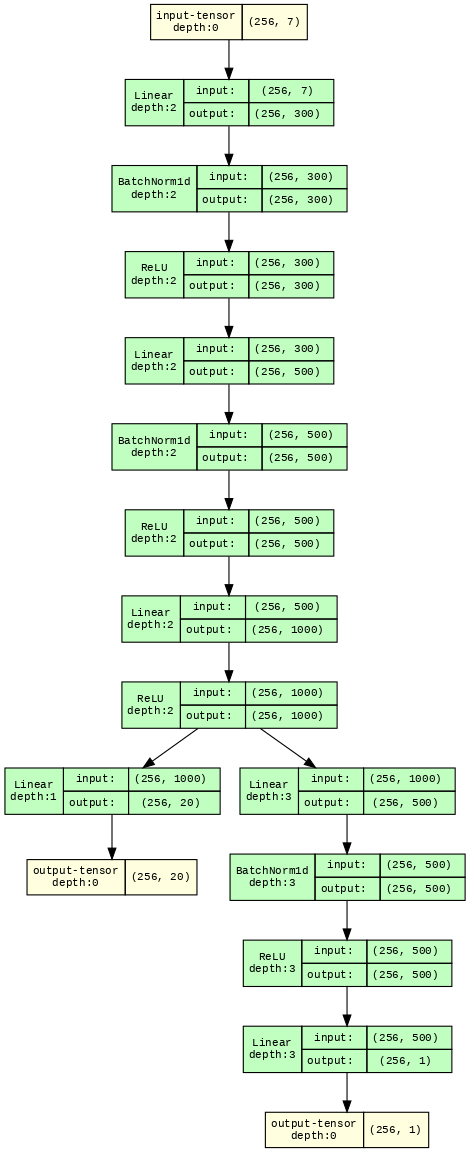

In [ ]:
model_branched_mlp_graph = BranchedFCNetwork(neck_features=1000)

model_graph = draw_graph(model_branched_mlp_graph, input_size=(256,7))
model_graph.visual_graph

# Модель Branched Fully Connected Separate

Отличие этой модели от предыдущей: здесь выходы с длинных ветвей не конкатенируются внутри модели. Каждый выход из каждой длинной ветви умножается на свой коэффициент, с которым он входит в выражение для ошибки.

### Проверка батча

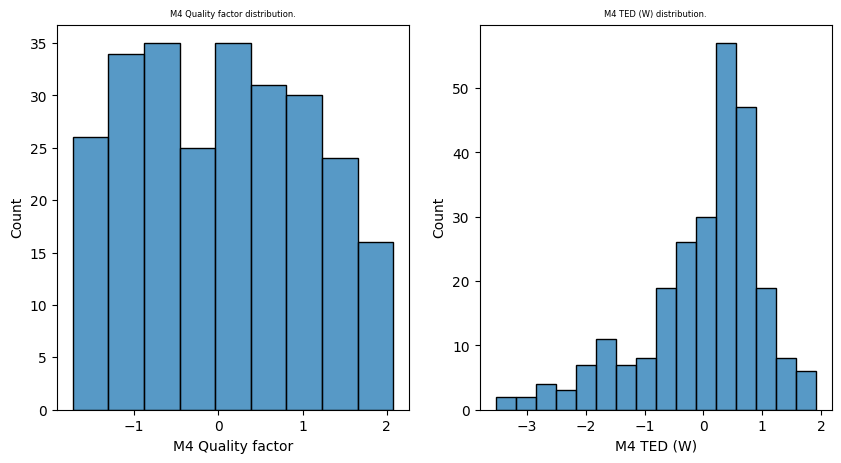

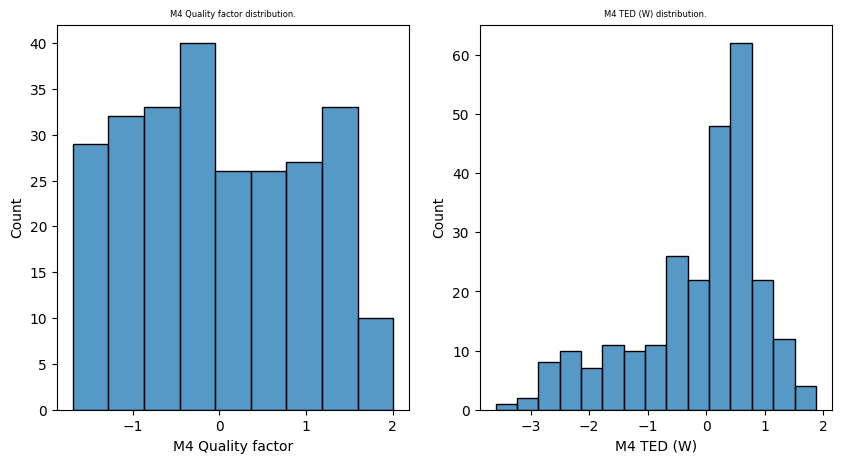

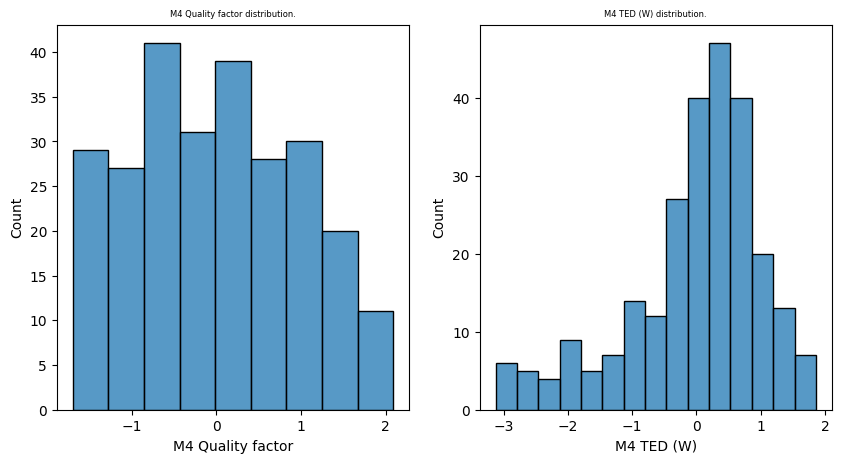

In [ ]:
x_train_check, y_train_check = next(iter(train_loader))
x_val_check, y_val_check = next(iter(val_loader))
x_test_check, y_test_check = next(iter(test_loader))

x_train_check, y_train_check = pd.DataFrame(x_train_check.numpy()), pd.DataFrame(y_train_check.numpy())
x_val_check, y_val_check = pd.DataFrame(x_val_check.numpy()), pd.DataFrame(y_val_check.numpy())
x_test_check, y_test_check = pd.DataFrame(x_test_check.numpy()), pd.DataFrame(y_test_check.numpy())

x_train_check.columns = param_names_x
x_val_check.columns = param_names_x
x_test_check.columns = param_names_x
y_train_check.columns = param_names_y
y_val_check.columns = param_names_y
y_test_check.columns = param_names_y

plot_distribution(y_train_check, indices_to_plot=[16, 18], log_scale=False)
plot_distribution(y_val_check, indices_to_plot=[16, 18], log_scale=False)
plot_distribution(y_test_check, indices_to_plot=[16, 18], log_scale=False)

### Функции для обучения

In [ ]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calculate_val_metrics_branched_sep(model, data_loader, criterion, output_coeffs):
    y_log = torch.empty(size=[0, 20]).to(device)
    output_log = torch.empty(size=[0, 20]).to(device)

    for batch in data_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        output_1, output_2 = model(x)
        output = output_1 * output_coeffs[0] + output_2 * output_coeffs[1]
        y_log = torch.cat((y_log, y), dim=0)
        output_log = torch.cat((output_log, output), dim=0)

    output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
        
    return output_dict

In [ ]:
def train_branched_sep(model, criterion, optimizer, plot_par, num_epochs=10, loss_coeffs=[0.2, 1], output_coeffs = [0.25, 0.75], tag="cifar10"):
    pp = ProgressPlotter()

    for epoch in range(num_epochs):
        y_log = torch.empty(size=[0, 20]).to(device)
        output_log = torch.empty(size=[0, 20]).to(device)

        model.train()
        for batch in train_loader:     # кусок данных для обучения
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # На выходе модели имеем один полноценный тензор и один тензор, объединяющий num_pars_y одиночных тензоров из длинных ветвей
            output_1, output_2 = model(x)

            # Ошибка на короткой ветви
            loss_1 = criterion(output_1, y)

            # Ошибки на длинных ветвях
            loss_branches = []
            for branch_index in range(0, num_pars_y):
                loss_branches.append(criterion(output_2[:, branch_index], y[:, branch_index]))

            # Суммарная ошибка на длинных ветвях с учетом весов
            loss_2 = loss_coeffs[1] * loss_branches[0]
            for branch_index in range(1, num_pars_y):
                loss_2 += loss_coeffs[branch_index + 1] * loss_branches[branch_index]
            
            # Полная ошибка
            loss = loss_1 + loss_2

            # Выход модели - среднее между предсказаниями короткой и длинной ветви с весами
            output = output_1 * output_coeffs[0] + output_2 * output_coeffs[1]

            y_log = torch.cat((y_log, y), dim=0)
            output_log = torch.cat((output_log, output), dim=0)

            loss.backward()
            optimizer.step()

        # Берем все объекты из тренировочного даталоадера и считаем метрики
        output_dict = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)

        # Logging
        if epoch % 10 ==0:
            pp.add_scalar('MSE_train', output_dict[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_train', output_dict[plot_par][1].cpu().detach().numpy())

        model.eval()
        output_dict_val = calculate_val_metrics_branched_sep(model, val_loader, criterion, output_coeffs)

        scheduler.step(output_dict_val[plot_par][0])

        if epoch % 10 ==0:
            pp.add_scalar('MSE_val', output_dict_val[plot_par][0].cpu().detach().numpy())
            pp.add_scalar('R2_val', output_dict_val[plot_par][1].cpu().detach().numpy())

        if epoch % 10 ==0:
            #pp.display([['loss_train', 'loss_val']])
            pp.display([['MSE_train','MSE_val'], ['R2_train','R2_val']])
    return pp

### Построение модели

In [ ]:
num_pars_x = x_train.shape[1]
num_pars_y = y_train.shape[1]

class BranchedSepFCNetwork(nn.Module):
    def __init__(self, neck_features, init_form='normal'):
        super().__init__()

        # Общая часть нейросети
        self.network_general = nn.Sequential(
            nn.Linear(in_features=num_pars_x, out_features=300, bias=False),
            nn.BatchNorm1d(num_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=int(neck_features / 2), bias=False),
            nn.BatchNorm1d(num_features=int(neck_features / 2)),
            nn.ReLU(),
            nn.Linear(in_features=int(neck_features / 2), out_features=neck_features, bias=True),
            nn.ReLU()
        )

        # Короткая ветвь нейросети
        self.network_short = nn.Linear(in_features=neck_features, out_features=num_pars_y, bias=True)

        # Длинные ветви нейросети (по одной длинной ветви на каждый параметр)
        self.network_branches = nn.ModuleList()
        for branch_index in range(0, num_pars_y):
            self.network_branches.append(BranchBlock(in_features=neck_features))
        
        self.init_form = init_form
        if self.init_form is not None:
            self.init()
    
    def forward(self, x):
        batch_size_x = x.shape[0]

        # Проходим по общим слоям
        x = self.network_general(x)

        # Прохожим по короткой ветви
        out_1 = self.network_short(x)

        # Проходим по длинным ветвям
        out_2 = torch.empty([batch_size_x, 0]).to(device)
        for branch_index in range(0, num_pars_y):
            out_temp = self.network_branches[branch_index](x)
            out_2 = torch.cat((out_2, out_temp), dim=1)
        return out_1, out_2
    
    def init(self):
        relu_gain = torch.nn.init.calculate_gain('relu')
        for child in self.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight)
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

class BranchBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=500, bias=False),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1, bias=False)
        )
    
    def forward(self, x):
        out = self.network(x)
        return out

### Процесс обучения модели

Задаем веса вычисления ошибки и веса слияния короткой и длинных ветвей:

In [ ]:
# Freq, Q, Eff mass, TED, Noise
loss_coeffs = [0.1,                     # для слияния короткой и длинной ветвей
               10, 2, 2, 2, 2, # M1
               1, 1, 1, 1, 1, # M2
               0.7, 0.7, 0.7, 0.7, 0.7, # M3
               1, 1, 1, 1, 1            # M4
               ]

coeff_1 = 0
output_coeffs = [coeff_1, 1 - coeff_1]

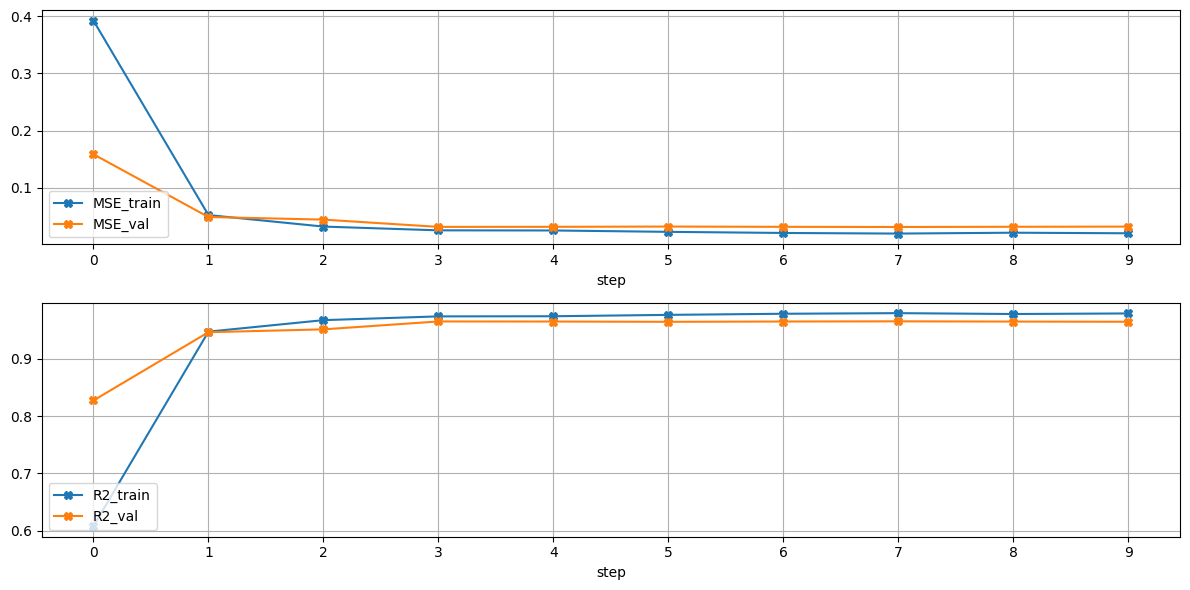

In [ ]:
model_branched_sep = BranchedSepFCNetwork(neck_features=1000, init_form='normal').to(device)
optimizer = torch.optim.Adam(model_branched_sep.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=1e-8, verbose=True)
plot_par = 'M1 Eigenfrequency (Hz)'
criterion = nn.MSELoss()
pp = train_branched_sep(model_branched_sep, criterion, optimizer, plot_par, num_epochs=100, loss_coeffs=loss_coeffs, output_coeffs=output_coeffs)

Проверка на тестовом датасете:

In [ ]:
loss = 0
y_log = torch.empty(size=[0, 20]).to(device)
output_log = torch.empty(size=[0, 20]).to(device)

for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)

    output_1, output_2 = model_branched_sep(x)
    output = output_coeffs[0] * output_1 + output_coeffs[1] * output_2

    y_log = torch.cat((y_log, y), dim=0)
    output_log = torch.cat((output_log, output), dim=0)

    loss += mse_loss(output, y).item()

output_dict_test_branched_sep = calculate_metrics_torch(y_true=y_log, y_pred=output_log, param_names=param_names_y)
for name in output_dict_test_branched_sep.keys():
    for index in range(0, len(output_dict_test_branched_sep[name])):
        output_dict_test_branched_sep[name][index] = output_dict_test_branched_sep[name][index].item()
print(output_dict_test_branched_sep)

{'M1 Eigenfrequency (Hz)': [0.02955903671681881, 0.9708495140075684], 'M1 Quality factor': [0.00876238290220499, 0.9912829995155334], 'M1 Effective mass (kg)': [0.0023137936368584633, 0.9976710081100464], 'M1 TED (W)': [0.03212233632802963, 0.9649455547332764], 'M1 Noise (kg^2/s^3)': [0.008427618071436882, 0.9909306168556213], 'M2 Eigenfrequency (Hz)': [0.01290416531264782, 0.9872270226478577], 'M2 Quality factor': [0.007952727377414703, 0.9920027256011963], 'M2 Effective mass (kg)': [0.0023124725557863712, 0.9976757764816284], 'M2 TED (W)': [0.022170672193169594, 0.9762029647827148], 'M2 Noise (kg^2/s^3)': [0.004098744597285986, 0.9956042766571045], 'M3 Eigenfrequency (Hz)': [0.009698466397821903, 0.9904153943061829], 'M3 Quality factor': [0.007692520972341299, 0.9922025799751282], 'M3 Effective mass (kg)': [0.0030793026089668274, 0.996889054775238], 'M3 TED (W)': [0.01979435794055462, 0.9790679812431335], 'M3 Noise (kg^2/s^3)': [0.0033948386553674936, 0.9963727593421936], 'M4 Eigenfr

Время работы нейросети:

In [ ]:
print(get_elapsed_time(model=model_branched_sep, data_loader=train_loader, num_samples=200))

0.008782148361206055


# Сравнение качества предсказаний нейросетей

In [ ]:
def compare_models(dict_list, model_names, param_names, modes, sharey, apply_log_mse, apply_log_r2):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), sharey=sharey)

    for row_index in range(0, 2):

        for col_index in range(0, 5):
            
            for model_index in range(0, len(model_names)):
                points_to_plot = []
                for mode in modes:
                    points_to_plot.append(dict_list[model_index][f'M{mode} {param_names[col_index]}'][row_index])

                ax[row_index, col_index].plot(modes, points_to_plot, label=model_names[model_index])

            # Дообработка графиков MSE
            if row_index == 0:
                if apply_log_mse:
                    ax[row_index, col_index].set_yscale('log')

                ax[row_index, col_index].set_ylabel('MSE Loss')
                ax[row_index, col_index].set_title(f"{param_names[col_index]} MSE Loss", fontsize=2 * 6)

            # Дообработка графиков R2
            if row_index == 1:
                if apply_log_r2:
                    ax[row_index, col_index].set_yscale('log')
                
                ax[row_index, col_index].set_ylabel('R2 Loss')
                ax[row_index, col_index].set_title(f"{param_names[col_index]} R2 Score", fontsize=2 * 6)

            ax[row_index, col_index].set_xlabel('Mode number')
            ax[row_index, col_index].tick_params(axis='y', labelleft=True)
            ax[row_index, col_index].set_xticks(modes)
            ax[row_index, col_index].grid(visible=True)
            ax[row_index, col_index].legend()
    plt.plot()

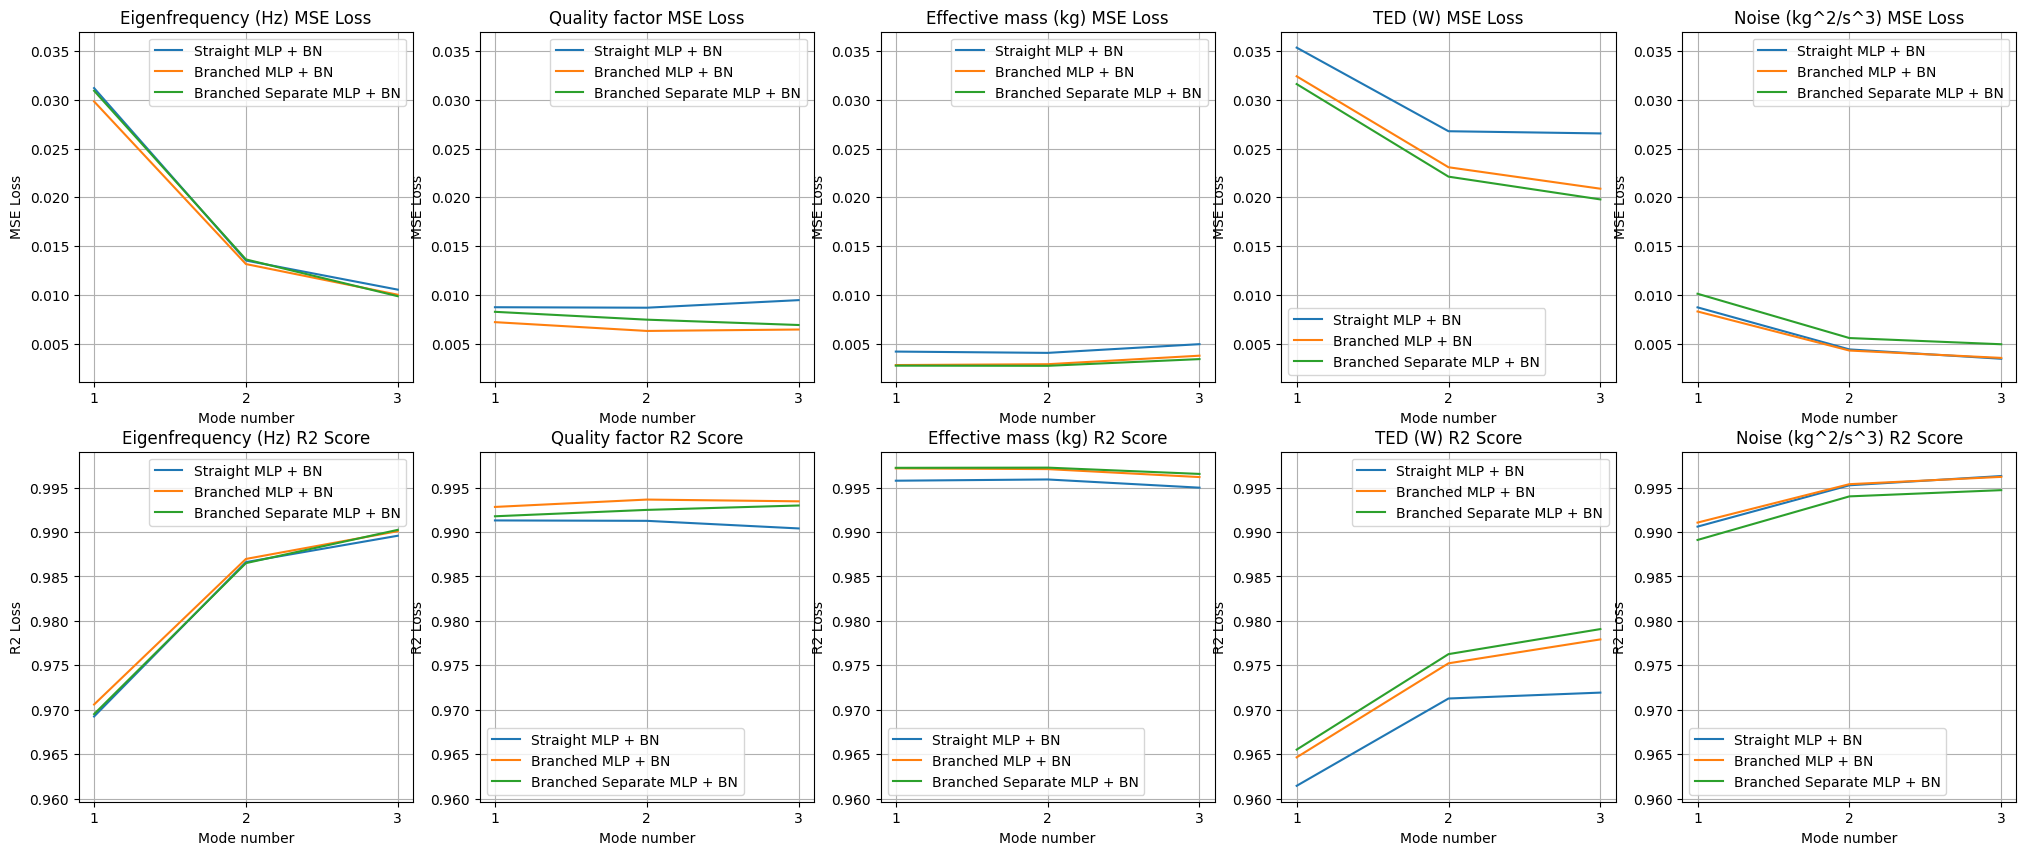

In [ ]:
modes = [1, 2, 3]
param_names = param_save
dict_list = [output_dict_test_mlp, output_dict_test_branched, output_dict_test_branched_sep]
model_names = ['Straight MLP + BN', 'Branched MLP + BN', 'Branched Separate MLP + BN']

compare_models(dict_list=dict_list,
               model_names=model_names,
               param_names=param_names,
               modes=modes,
               sharey='row',
               apply_log_mse=False,
               apply_log_r2=False)

# Дополнительное тестирование

## Анализ реальных устройств

Пробуем дать модели на вход тестовые данные: либо параметры реально существующего устройства, либо параметры устройств, сгенерированных в FEM, но лежащие на границах распределений параметров.

In [52]:
gate_U = 0
gate_D = 300

x_real = pd.DataFrame([[70, 200, 100, 30, 1, gate_D, gate_U, 0],
                       [30, 170, 60, 80, 1, gate_D, gate_U, 0],
                       [30, 300, 100, 30, 1, gate_D, gate_U, 0],
                       [150, 300, 100, 30, 1, gate_D, gate_U, 0]]) # это параметры реально изготовленного устройства
x_real.columns = x_train.columns

y_real_ = pd.DataFrame(np.ones(shape=(4, 20)))
y_real_.columns = y_train.columns
y_real_.iloc[0, 0] = 2.166e6
y_real_.iloc[1, 0] = 6.3e6
y_real_.iloc[2, 0] = 11.6e6
y_real_.iloc[3, 0] = 1.66e6

x_real = s.transform_real_x(x_real)

x_real_torch = torch.tensor(x_real.iloc[:, :].values, dtype=torch.float32).to(device)

# Подаем реальные данные на вход модели
with torch.no_grad():
    y_real_pred = model_mlp(x_real_torch)
y_real_pred = pd.DataFrame(y_real_pred.detach().cpu().numpy())

x_real, y_real_pred = s.reverse_transform(x_real, y_real_pred, concat_required=False)
y_real_pred = pd.DataFrame(y_real_pred)
y_real_pred.columns = y_train.columns

real_pred = pd.concat([x_real, y_real_pred], axis=1)
real_pred.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,70.0,200.0,100.0,30.0,1.0,300.0,0.0,0.0,2224824.5,5.831592e+05,...,6366506.50,7.115568e+05,2.436372e-15,2.463118e-28,3.203331e-12,9521114.0,487591.875,2.330099e-15,6.569489e-28,4.980613e-12
1,30.0,170.0,60.0,80.0,1.0,300.0,0.0,0.0,5010857.5,1.014749e+06,...,15633631.00,1.467418e+06,8.324930e-16,6.205109e-28,2.991475e-12,22223148.0,584377.000,6.805380e-16,1.411587e-27,3.672223e-12
2,30.0,300.0,100.0,30.0,1.0,300.0,0.0,0.0,5547937.5,3.913970e+06,...,20184986.00,3.948154e+06,1.673895e-15,4.234113e-28,6.031430e-12,33474492.0,2638181.750,1.734258e-15,8.660480e-28,6.937587e-12
3,150.0,300.0,100.0,30.0,1.0,300.0,0.0,0.0,1002331.5,4.494144e+05,...,3137980.25,5.159458e+05,8.907751e-15,1.231085e-28,4.495575e-12,4012715.5,402079.500,8.641256e-15,1.661262e-28,7.464113e-12


## Анализ работы тандема нейросетей

In [45]:
y_real_unnecessary_pars = y_real_pred.iloc[0, 2:].values.flatten().tolist()

In [46]:
param_list = [2.166e6, 5e5]
param_list += y_real_unnecessary_pars
y_real = pd.DataFrame([param_list])
y_real.columns = y_train.columns

y_real = s.transform_real_y(y_real)
y_real_torch = torch.tensor(y_real.iloc[:, :].values, dtype=torch.float32).to(device)

# Подаем реальные данные на вход инверсной модели
with torch.no_grad():
    x_real_pred = model_inverse(y_real_torch)
x_real_pred = pd.DataFrame(x_real_pred.detach().cpu().numpy())
print(x_real_pred)

x_real_pred, y_real = s.reverse_transform(x_real_pred, y_real, concat_required=False)
x_real_pred = pd.DataFrame(x_real_pred)
x_real_pred.columns = x_train.columns

real_pred = pd.concat([x_real_pred, y_real], axis=1)
real_pred.head()

          0         1         2         3         4         5         6  \
0 -0.400204 -1.167202 -0.986542 -0.155784 -0.233314  1.077757 -1.162037   

          7  
0 -1.822802  


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,59.693684,212.10318,109.746864,28.617161,1.29243,505.463074,2.271641,-115801104.0,2166000.0,500000.0,...,6837998.5,719282.125,2.373817e-15,2.923174e-28,3.680231e-12,9728036.0,445205.5,2.290177e-15,7.527683e-28,5.432964e-12


## Анализ специально сгенерированного датасета

Теперь дадим модели на вход специально сгенерированные параметры и посмотрим значения метрик качества. Сначала разделим спец-датасет на X- и Y-данные:

In [ ]:
df_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,1.0,50.000000,50.000000,5.000000,0.010000,10.000000,0.000100,2.803040e+09,2999.961507,4.463888e-18,...,2.368622e+10,2999.925303,1.484737e-18,6.473942e-24,9.672427e-13,3.611185e+10,2735.071292,3.025101e-19,2.205758e-24,4.907778e-13
1,4.0,121.052632,105.263158,13.684211,47.376842,166.315789,9.473768,6.949824e+08,5929.643072,9.340537e-17,...,6.355575e+09,1.016613,3.301764e-17,3.761489e-17,1.176682e-12,7.653863e+09,16.404370,2.965607e-17,2.262673e-18,1.262608e-12
2,5.0,144.736842,123.684211,16.578947,63.165789,218.421053,12.631658,5.553440e+08,6189.189109,1.645929e-16,...,9.429889e+09,6740.302216,5.559638e-17,9.081318e-21,1.035849e-11,1.352729e+10,5824.391008,1.158770e-17,3.373238e-21,1.819410e-11
3,6.0,168.421053,142.105263,19.473684,78.954737,270.526316,15.789547,4.623805e+08,6132.007640,2.647434e-16,...,8.198813e+09,6667.229640,8.954131e-17,1.094781e-20,1.412529e-11,1.170267e+10,7090.435494,1.873763e-17,3.230065e-21,2.537991e-11
4,70.0,286.842105,234.210526,33.947368,157.899474,531.052632,31.578995,1.560621e+06,16779.496146,7.023254e-15,...,5.561491e+06,15767.407884,6.708401e-15,3.859902e-24,1.096633e-11,8.664295e+06,15068.122275,7.799296e-15,6.990750e-24,1.547307e-11


In [ ]:
param_general = ['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)']
param_save = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

# Делим данные на Х и У
x_test, y_test = split_df(df_test, param_general=param_general, param_save=param_save, mode_number=4)

x_test, y_test = s.transform(x_test, y_test)

In [ ]:
y_test.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,11.526319,-2.476373,-10.532257,-0.682252,17.278658,11.082407,-2.473801,-10.955109,4.119754,7.976824,12.156881,-2.451848,-11.788437,-1.727309,1.000324e+01,11.883162,-2.434915,-13.467618,-2.709719,1.198872e+00
1,9.807253,-2.249520,-7.220081,-0.244281,11100.026970,9.400696,-2.277233,-7.401680,10.136731,6358.644509,10.613520,-2.692595,-8.394769,-1.580043,5.914189e+07,10.123882,-2.654338,-8.473576,-1.959912,1.362505e+06
2,9.530763,-2.229423,-6.603021,-0.120538,11150.071764,9.130176,-2.271614,-6.779477,10.421324,6401.067703,11.076392,-2.151577,-7.824662,0.054209,1.427838e+04,10.769686,-2.185576,-9.497066,0.157064,2.031120e+03
3,9.304937,-2.233850,-6.085340,-0.004553,11139.068560,8.909210,-2.284327,-6.177634,10.653702,6888.365680,10.912273,-2.157443,-7.303237,0.287245,1.721307e+04,10.605381,-2.083394,-8.973636,0.421187,1.944906e+03
4,2.289364,-1.409388,-2.514705,0.553184,8.397050,2.307112,-1.418313,-2.499761,0.441713,7.021500,2.353055,-1.426895,-2.580669,0.097053,5.893186e+00,2.431189,-1.439516,-2.404756,0.028521,4.080232e+00


Смотрим качество целевых метрик:

In [ ]:
y_pred = model_boost.predict(x_test)
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred)))

MSE на тестовом наборе: 12498642916853.361
R2 на тестовом наборе: 0.360


In [ ]:
df_pred = s.unscale_pred(x_test=x_test, y_pred=y_pred, concat_required=True)
df_pred.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,1.0,50.000000,50.000000,5.000000,0.010000,10.000000,0.000100,2934097.000,13529.625977,2.309139e-15,...,9935986.0,13567.863281,2.299711e-15,3.760544e-13,1.122976e-24,15878361.0,11013.442383,1.676175e-15,2.258851e-13,-5.309736e-24
1,4.0,121.052632,105.263158,13.684211,47.376842,166.315789,9.473768,2843721.000,12939.006836,2.244956e-15,...,9847256.0,12278.220703,2.250973e-15,5.938815e-12,1.218227e-24,15465296.0,10425.075195,1.660328e-15,8.210193e-12,3.906905e-24
2,5.0,144.736842,123.684211,16.578947,63.165789,218.421053,12.631658,2590644.500,13107.118164,2.214637e-15,...,9549769.0,12944.126953,2.234578e-15,6.195265e-12,1.343366e-24,15301428.0,10758.188477,1.657490e-15,6.699335e-12,3.906905e-24
3,6.0,168.421053,142.105263,19.473684,78.954737,270.526316,15.789547,2526505.000,12029.104492,2.807664e-15,...,9394975.0,11096.011719,2.815641e-15,5.703891e-12,1.744346e-24,14777240.0,9766.999023,2.051380e-15,6.394311e-12,3.906905e-24
4,70.0,286.842105,234.210526,33.947368,157.899474,531.052632,31.578995,1761708.375,16189.522461,5.484219e-15,...,6088959.0,15669.146484,6.158182e-15,7.725797e-12,2.261540e-24,8784258.0,15000.768555,5.148101e-15,1.152940e-11,3.408741e-24
